# Deep GP Unsupervised Learning

## Zhenwen Dai and Neil D. Lawrence

This notebook explores the deep Gaussian processes' capacity to perform unsupervised learning. 

We will look at a sub-sample of the MNIST digit data set.

This notebook depends on [GPy](https://github.com/SheffieldML/GPy) and [PyDeepGP](https://github.com/SheffieldML/PyDeepGP). These libraries can be installed via pip:
```
pip install GPy
pip install git+https://github.com/SheffieldML/PyDeepGP.git
```

In [1]:
import deepgp
import GPy
import numpy as np
%matplotlib inline
from pylab import *
from IPython.display import display
from gp_tutorial import ax_default, meanplot, gpplot

First load in the MNIST data set from scikit learn. This can take a little while because it's large to download.

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

Sub-sample the dataset to make the training faster.

In [3]:
np.random.seed(0)
digits = [0,1,2,3,4]
N_per_digit = 100
Y = []
labels = []
for d in digits:
    imgs = mnist['data'][mnist['target']==d]
    Y.append(imgs[np.random.permutation(imgs.shape[0])][:N_per_digit])
    labels.append(np.ones(N_per_digit)*d)
Y = np.vstack(Y).astype(np.float64)
labels = np.hstack(labels)
Y /= 255.

### Fit a Deep GP

We're going to fit a Deep Gaussian process model to the MNIST data with two hidden layers. Each of the two Gaussian processes (one from the first hidden layer to the second, one from the second hidden layer to the data) has an exponentiated quadratic covariance.

In [4]:
num_latent = 2
num_hidden_2 = 5
m = deepgp.DeepGP([Y.shape[1],num_hidden_2,num_latent],
                  Y,
                  kernels=[GPy.kern.RBF(num_hidden_2,ARD=True), 
                           GPy.kern.RBF(num_latent,ARD=False)], 
                  num_inducing=50, back_constraint=False, 
                  encoder_dims=[[200],[200]])

### Initialization

Just like deep neural networks, there are some tricks to intitializing these models. The tricks we use here include some early training of the model with model parameters constrained. This gives the variational inducing parameters some scope to tighten the bound for the case where the noise variance is small and the variances of the Gaussian processes are around 1. 

In [5]:
m.obslayer.likelihood.variance[:] = Y.var()*0.01
for layer in m.layers:
    layer.kern.variance.fix(warning=False)
    layer.likelihood.variance.fix(warning=False)


We now we optimize for a hundred iterations with the constrained model. 

In [6]:
m.optimize(messages=False,max_iters=100)

Now we remove the fixed constraint on the kernel variance parameters, but keep the noise output constrained, and run for a further 100 iterations. 

In [7]:
for layer in m.layers:
    layer.kern.variance.constrain_positive(warning=False)
m.optimize(messages=False,max_iters=100)

Finally we unconstrain the layer likelihoods and allow the full model to be trained for 1000 iterations.

In [8]:
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m.optimize(messages=True,max_iters=10000)

### Visualize the latent space of the top layer

Now the model is trained, let's plot the mean of the posterior distributions in the top latent layer of the model. 

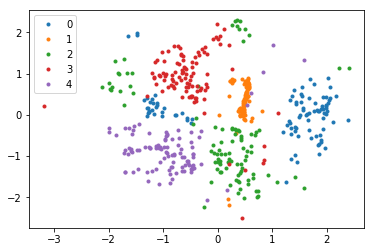

In [9]:
for d in digits:
    plot(m.layer_1.X.mean[labels==d,0],m.layer_1.X.mean[labels==d,1],'.',label=str(d))
_ = legend()

### Visualize the latent space of the intermediate layer

We can also visualize dimensions of the intermediate layer. First the lengthscale of those dimensions is given by

In [10]:
m.obslayer.kern.lengthscale

index,deepgp.obslayer.rbf.lengthscale,constraints,priors
[0],4.44424025,+ve,
[1],6.90055669,+ve,
[2],7.53546881,+ve,
[3],6.10740572,+ve,
[4],4.94874460,+ve,


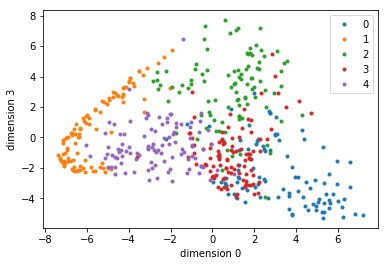

In [11]:
dims=[0, 3]
for d in digits:
    plot(m.obslayer.X.mean[labels==d,dims[0]],
         m.obslayer.X.mean[labels==d,dims[1]],
         '.', label=str(d))
legend()
xlabel('dimension ' + str(dims[0]))
ylabel('dimension ' + str(dims[1]))

### Generate Test Examples

Now we can take a look at a sample from the model, by drawing a Gaussian random sample in the latent space and propagating it through the model. 

In [18]:
rows = 10
cols = 20
t=np.linspace(-1, 1, rows*cols)[:, None]
kern = GPy.kern.RBF(1,lengthscale=0.05)
cov = kern.K(t, t)
x = np.random.multivariate_normal(np.zeros(rows*cols), cov, num_latent).T

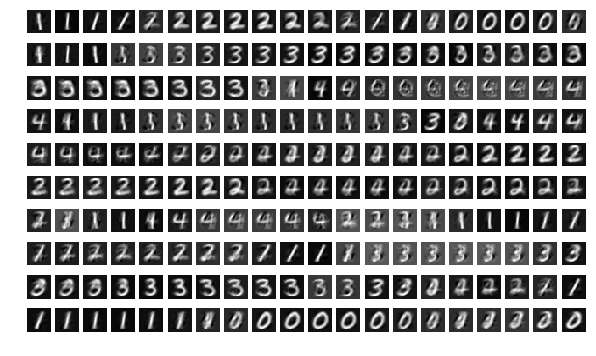

In [19]:
#x = np.random.randn(rows*cols,num_input)*0.5
yt = m.predict(x)
fig, axs = plt.subplots(rows,cols,figsize=(10,6))
for i in range(rows):
    for j in range(cols):
        #v = np.random.normal(loc=yt[0][i*cols+j, :], scale=np.sqrt(yt[1][i*cols+j, :]))
        v = yt[0][i*cols+j, :]
        axs[i,j].imshow(v.reshape(28,28), 
                        cmap='gray', interpolation='none',
                        aspect='equal')
        axs[i,j].set_axis_off()
fig.savefig("../../slides/diagrams/digit-samples-deep-gp.svg", transparent=True)

In [14]:
np.random.normal?